# Исследование работы сервиса аренды самокатов

Исследователь - аналитик популярного сервиса аренды самокатов `GoFast`.  
Для исследования аналитику передали данные о некоторых пользователях сервиса из нескольких городов, а также об их поездках.  
Поставлена задача проанализировать данные и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти.  
Чтобы совершать поездки по городу, пользователи сервиса `GoFast` пользуются мобильным приложением. Сервисом можно пользоваться:  
* без подписки  
  - абонентская плата отсутствует;  
  - стоимость одной минуты поездки - 8 рублей;  
  - стоимость старта (начала поездки) - 50 рублей;  
* с подпиской `Ultra`  
  - абонентская плата - 199 рублей в месяц;  
  - стоимость одной минуты поездки - 6 рублей;  
  - стоимость старта - бесплатно.  

     План работы:  
+ открыть файл с данными и изучить общую информацию;  
+ выполнить предобработку данных (пропущенные значения, типы данных, дубликаты);  
+ исследовать данные (частоту встречаемости городов, соотношение пользователей с подпиской и без, возраст пользователей, расстояние и продолжительность поездок);  
+ объединить данные в один датафрейм, выделить отдельно данные по пользователям с подпиской и без;  
+ посчитать помесячную выручку по каждому пользователю за каждый месяц;  
+ выдвинуть гипотезы и проверить их;  
+ изучить распределения.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
import math
from scipy import stats as st
from math import factorial, sqrt
from scipy.stats import binom, norm

# Шаг 1. Загрузка данных

Напишем функцию для оптимизации кода вывода первичной информации

In [2]:
def information(dataset):
    display(dataset.head())
    display()
    display(dataset.info())

Считаем первый csv-файл с данными о пользователях, сохраним его в датафрейм `users` и изучим общую информацию о датафрейме `users`

In [3]:
users = pd.read_csv('/datasets/users_go.csv')

information(users)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


None

Считаем второй csv-файл с данными о поездках, сохраним его в датафрейм `rides`, при загрузке данных добавим параметр `parse_dates`, чтобы перевести столбец с датами в нужный форма
А также изучим общую информаци о датафрейме `rides`

In [4]:
rides = pd.read_csv('/datasets/rides_go.csv', parse_dates=['date'])

rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


Считаем третий csv-файл с данными о подписках, сохраним его в датафрейм `subscriptions` и изучим общую информацию о датафрейме `subscriptions`

In [5]:
subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')

subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


**Вывод.** Датафрейм `users` содержит информацию о пользователях: уникальный идентификатор пользователя, имя пользователя, возраст, город и тип подписки (`free`, `ultra`). Датафрейм `users` содержит 1565 строк и 5 столбцов. Названия столбцов корректные. Типы значений в двух столбцах целочисленные и в трёх столбцах `object`. Нулевые значения предположительно отсутствуют.

Датафрейм `rides` содержит информацию о поездках: уникальный идентификатор пользователя, расстояние, которое пользователь проехал в текущей сессии (в метрах), продолжительность сессии (в минутах) - время с того момента, как пользователь нажал кнопку "Начать поездку" до момента, как он нажал кнопку "Завершить поездку", дата совершения поездки. Датафрейм `rides` содержит 18068 строк и 4 столбца. Названия столбцов корректные. Типы значений в одном столбце целочисленные, в двух столбцах вещественные и в одном столбце `datetime`. Нулевые значения предположительно отсутствуют.

Датафрейм `subscriptions` содержит информацию о подписках: тип подписки, стоимость одной минуты поездки по данной подписке, стоимость начала поездки, стоимость ежемесячного платежа. Датафрейм `subscriptions` содержит 2 строки и 4 столбца. Названия столбцов корректные. Типы значений в трех столбцах целочисленные, в одном столбце `object`. Нулевые значения предположительно отсутствуют.

# Шаг 2. Предобработка данных

**Анализируемый период**

Выведем на экран минимальное и максимальное значения в столбце `date` датафрейма `rides`

In [6]:
display(rides['date'].min(), rides['date'].max())

Timestamp('2021-01-01 00:00:00')

Timestamp('2021-12-30 00:00:00')

Данные собраны за 2021 год - с 1 января 2021 года по 30 декабря 2021 года, то есть за один год. Из столбца с датами нужно извлечь информацию о месяце. Добавим новый столбец с номером месяца.

На основе столбца `date` датафрейма `rides` создадим в этом датафрейме новый столбец с номером месяца. Проверим, выведем на экран первые 20 строк датафрейма `rides`

In [7]:
rides['month'] = rides['date'].dt.month

rides.head(20)

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8
5,1,2770.890808,16.650138,2021-10-09,10
6,1,3039.020292,14.927879,2021-10-19,10
7,1,2842.118050,23.117468,2021-11-06,11
8,1,3412.690668,15.238072,2021-11-14,11
9,1,748.690645,15.041884,2021-11-22,11


**Пропуски и дубликаты**

Проверим на наличие пропусков все три датафрейма

In [8]:
print(users.isna().sum())
print()
print(rides.isna().sum())
print()
print(subscriptions.isna().sum())

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64


Пропусков нет. Это радует

Проверим на наличие явных дубликатов датафреймы `users` и `rides`

In [9]:
print(users.duplicated().sum(), rides.duplicated().sum())

31 0


В датафрейме `users` дубликаты есть, удалим их, индексацию обновим, датафрейм перезапишем. Проверим на наличие дубликатов датафрейм `users` после их удаления

In [10]:
users = users.drop_duplicates().reset_index(drop=True)

users.duplicated().sum()

0

Проверим на наличие неявных дубликатов

In [11]:
print(users['city'].unique(), users['subscription_type'].unique())

['Тюмень' 'Омск' 'Москва' 'Ростов-на-Дону' 'Краснодар' 'Пятигорск'
 'Екатеринбург' 'Сочи'] ['ultra' 'free']


**Вывод.** Нами выяснено, что данные собраны за год - с 1 января по 30 декабря 2021 года. В отдельный столбец `month` вынесены данные о месяце. Далее мы убедились в отсутствии пропущенных значений в данных. И, наконец, избавились от явных дубликатов и убедились в отсутствии неявных дубликатов. Таким образом, предобработка данных выполнена.

# Шаг 3. Исследовательский анализ данных

**Частота встречаемости городов**

Выведем количество пользователей в каждом городе как число упоминаний города в столбце 'city' датафрейма 'users'. Сохраним полученный Series как `users_city`

In [12]:
users_city = users['city'].value_counts()
users_city

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

Построим столбчатую диаграмму, при этом развернём график в горизонтальные бары, чтобы надписи по оси Х читались корректно

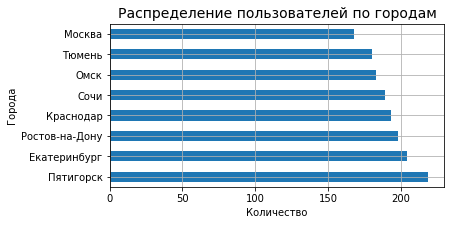

In [13]:
fig = plt.figure(figsize=(6, 3))
ax = users_city.plot.barh()
plt.title('Распределение пользователей по городам', fontsize=14)
plt.xlabel('Количество')
plt.ylabel('Города')
plt.grid()
plt.show()

Больше всего пользователей сервиса аренды самокатов GoFast в Пятигорске, Екатеринбурге, Ростове-на-Дону, а также в Краснодаре и Сочи. В Омске и Тюмени пользователей меньше, а самый низкий показатель числа пользователей в имеющихся данных - в Москве.  
Выясним, на сколько процентов отличается количество пользователей в разных городах.

Посчитаем отношение максимального и минимального количества пользователей по городам

In [14]:
round(users_city.max() / users_city.min(), 2)

1.3

Отношение максимального числа клиентов к минимальному по отдельным городам составляет примерно `1.3`, то есть количество пользователей в городах отличается на 30 % и меньше. Различие по числу пользователей в разных городах не является существенным для нашего исследования. Однако непонятно, почему эта разница не в пользу Москвы.

Применим к данным о распределении клиентов по городам метод `describe()`, чтобы получить числовое описание данных

In [15]:
display(users_city.describe().round(2))

count      8.00
mean     191.75
std       15.67
min      168.00
25%      182.25
50%      191.00
75%      199.50
max      219.00
Name: city, dtype: float64

Как видно из числового описания данных, среднее значение и медиана практически равны. Кроме того, стандартное отклонение очень маленькое, что позволяет утверждать, что данные однородны. Разница между городами по числу пользователей сервиса несущественная. 

**Соотношение пользователей с подпиской и без подписки**

Выведем число значений в столбце 'subscription_type' датафрейма 'users'

In [16]:
users['subscription_type'].value_counts()

free     835
ultra    699
Name: subscription_type, dtype: int64

Построим столбчатую диаграмму

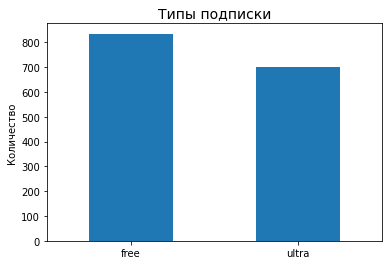

In [17]:
ax = users['subscription_type'].value_counts().plot.bar()
plt.title('Типы подписки', fontsize=14)
plt.ylabel('Количество')
plt.xticks(rotation=0)
plt.show()

Построим круговую диаграмму для отображения разности в доле клиентов

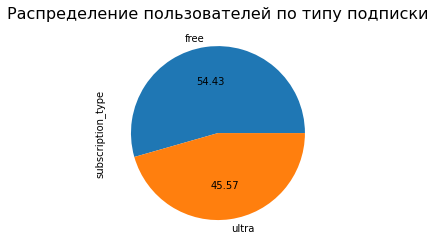

In [18]:
fig = plt.figure(figsize=(8, 4))
ax = users['subscription_type'].value_counts().plot.pie(autopct='%.2f')
plt.title('Распределение пользователей по типу подписки', fontsize=16)
plt.show()

Выясним, каково соотношение пользователей без подписки и с подпиской в численном выражении

In [19]:
(users.groupby('subscription_type')['user_id'].count()[0] / \
 users.groupby('subscription_type')['user_id'].count()[1]).round(2)

1.19

Как видно, круговая диаграмма показывает, что соотношение пользователей с подпиской и без подписки не слишком отличается, пользователи делят круг почти пополам. Пользователей без подписки по имеющимся данным несколько больше, чем пользователей с подпиской. В численном выражении соотношение составляет 1,1946, то есть пользователей без подписки примерно на 20 % больше, чем пользователей с подпиской. 

**Возраст пользователей**

Выведем на экран минимальный и максимальный возраст пользователей

In [20]:
print(users['age'].min(), users['age'].max())

12 43


Построим гистограмму распределения пользователей по возрасту

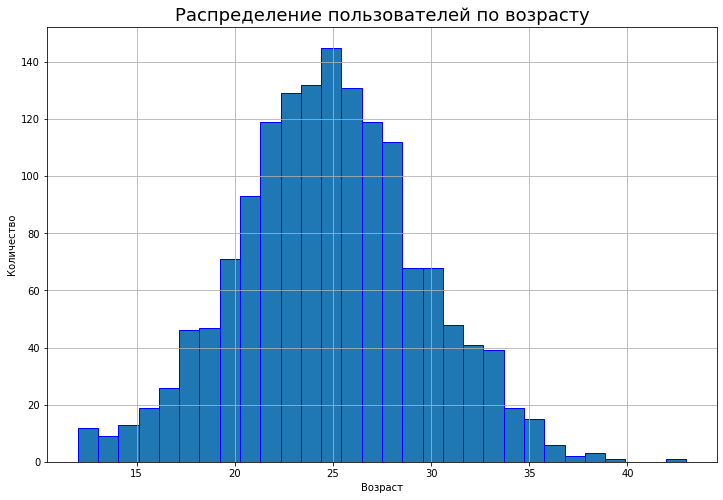

In [21]:
users['age'].hist(bins=30, figsize=(12, 8), edgecolor='b')
plt.title('Распределение пользователей по возрасту', fontsize=18)
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.show()

Пользователи сервиса - люди от 12 до 43 лет включительно. Большая часть пользователей имеет возраст от 19 до 38 лет. А самые активные пользователи сервиса находятся в возрасте от 22 до 28 лет. Распределение пользоватлей по возрасту нормальное.

Построим диаграмму размаха для распределения пользователей по возрасту

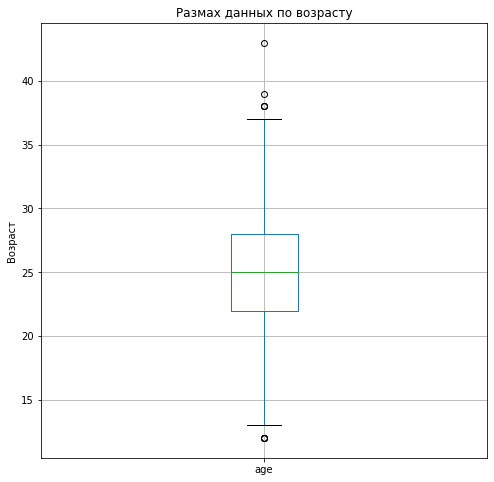

In [22]:
plt.figure(figsize=(8, 8))
users.boxplot('age')
plt.title('Размах данных по возрасту')
plt.ylabel('Возраст')
plt.grid(True)
plt.show()

Как видно из диаграммы размаха, медианный возраст клиентов сервиса составляет 25 лет, то есть половина клиентов моложе 25 лет, а другая половина - старше. Межквартильный размах показывает, что 50 % клиентов находятся в возрасте от 22 до 28 лет.  
Некоторые значения возраста являются аномальными для данного распределения - это значения 12 лет и значения старше 37 лет. Таких значений немного, это означает, что детям и людям старше 37 лет несвойственно пользоваться самокатами. Это, скорее, исключения. Однако аномальные данные удалять не будем, так как эти пользователи такие же клиенты сервиса и тоже заплатили за свои поездки.

**Расстояние, которое пользователь преодолел за одну поездку**

Выведем на экран минимальное и максимальное расстояние, которое пользователь преодолел за одну поездку (в метрах)

In [23]:
print(rides['distance'].min(), '; ', rides['distance'].max())

0.855682925681208 ;  7211.007744598519


Построим гистограмму распределения поездок по расстоянию за одну поездку

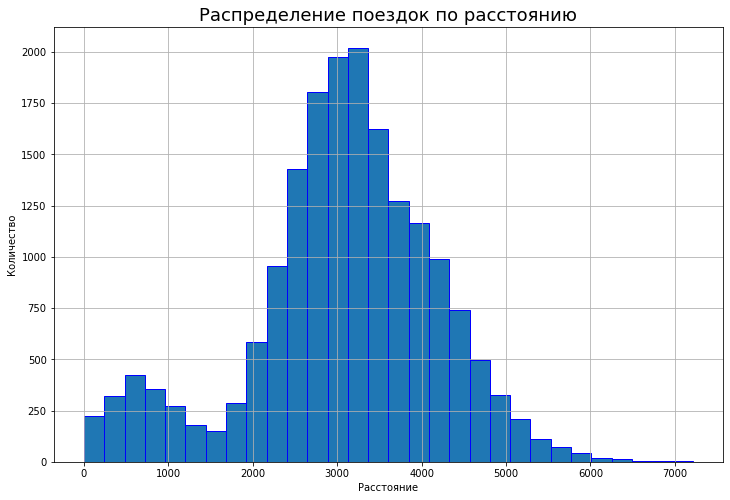

In [24]:
rides['distance'].hist(bins=30, figsize=(12, 8), edgecolor='b')
plt.title('Распределение поездок по расстоянию', fontsize=18)
plt.xlabel('Расстояние')
plt.ylabel('Количество')
plt.show()

Распределение близкое к нормальному, но имеется малый пик в небольших значениях. Поездки, совершённые пользователями, имели минимальную дистанцию 0,86 м, максимальную - 7211,01 м. Пик графика находится в точке около 3 километров. Есть также небольшой пик возле значения 500-700 метров, то есть некоторые пользователи берут самокат на очень короткие расстояния. Но всё же большинство пользователей проезжают от 2 до 5 километров. Можно предположить, что на короткие расстояния берут самокат неуверенные пользователи, которые только учатся использовать этот вид транспорта или приложение, с помощью которого используется сервис. Основную часть клиентов составляют опытные пользователи, которые применяют этот вид транспорта по прямому назначению - проехать из одного пункта в другой, который чаще всего не в пешей доступности. 

Построим диаграмму размаха для распределения пользователей по длине поездок

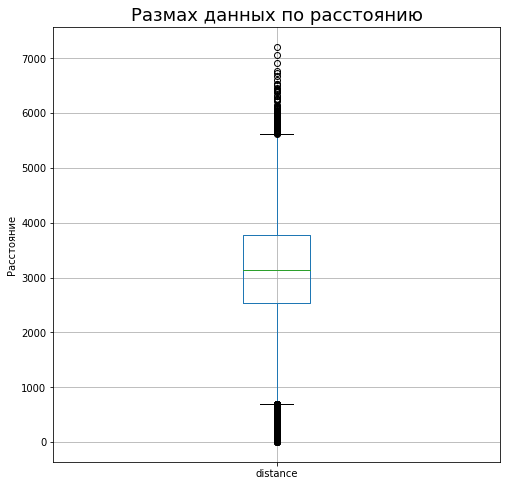

In [25]:
plt.figure(figsize=(8, 8))
rides.boxplot('distance')
plt.title('Размах данных по расстоянию', fontsize=18)
plt.ylabel('Расстояние')
plt.grid(True)
plt.show()

По диаграмме размаха можно определить, что расстояние поездок менее 700 метров и более 5700 метров являются аномальными для имеющихся данных (несмотря на то, что на значениях 500-700 метров имеется небольшое увеличение частот). И таких аномальных значений много. Это даёт возможность утверждать, что разброс данных большой. Воспользуемся методом  `describe()`, чтобы получить числовое описание данных.

In [26]:
display(rides['distance'].describe().round(2))

count    18068.00
mean      3070.66
std       1116.83
min          0.86
25%       2543.23
50%       3133.61
75%       3776.22
max       7211.01
Name: distance, dtype: float64

Среднее расстояние, проезжаемое пользователями, составляет 3070.66 метров, медианное расстояние - 3133.61 метра. Половина клиентов проезжает от 2543 до 3776 метров за одну поездку. Стандартное отклонение велико, что указывает на неоднородность совокупности. Разброс данных, действительно, большой.  
Удалять аномальные данные нельзя, так как их много, и эти данные имеют ценность.

**Продолжительность поездок**

Выведем на экран минимальную и максимальную продолжительность поездок (в минутах)

In [27]:
print(rides['duration'].min(), '; ', rides['duration'].max())

0.5 ;  40.82396261922424


Построим гистограмму распределения поездок по продолжительности

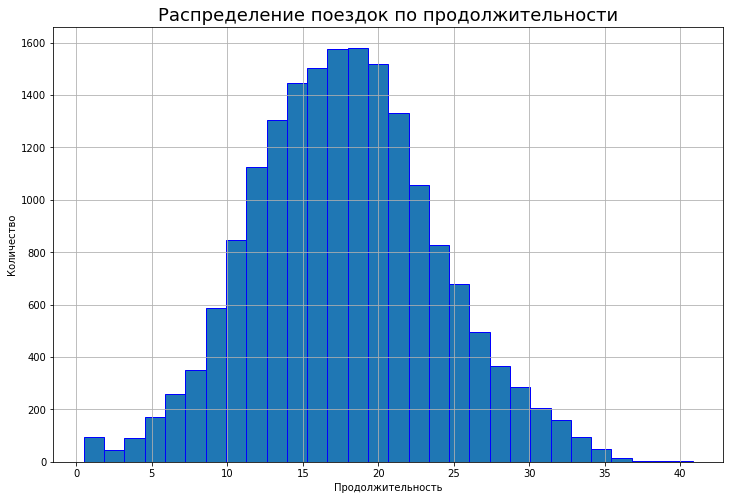

In [28]:
rides['duration'].hist(bins=30, figsize=(12, 8), edgecolor='b')
plt.title('Распределение поездок по продолжительности', fontsize=18)
plt.xlabel('Продолжительность')
plt.ylabel('Количество')
plt.show()

Распределение в целом близко к нормальному. Самая короткая по времени поездка 0,5 минуты, самая продолжительная - 40,8 минут. Чаще всего поездки имели продолжительность от 10 до 25 минут.

Построим диаграмму размаха для распределения пользователей по продолжительности поездок

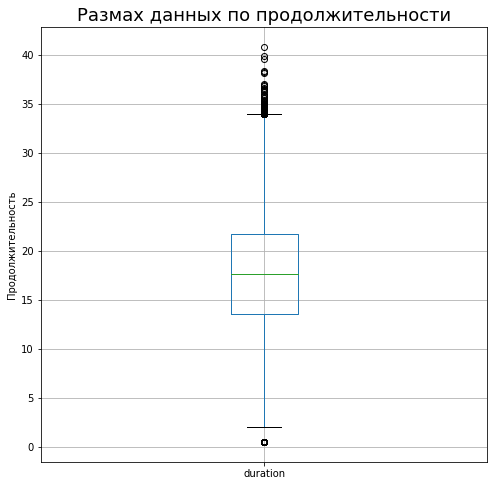

In [29]:
plt.figure(figsize=(8, 8))
rides.boxplot('duration')
plt.title('Размах данных по продолжительности', fontsize=18)
plt.ylabel('Продолжительность')
plt.grid(True)
plt.show()

По диаграмме размаха можно определить, что медианная продолжительность поездок составляет 18 минут. Половина клиентов сервиса пользуется самокатом от 13 до 22 минут. Короткими можно считать поездки от 2 до 13 минут, длинными - от 22 до 34 минут. Поездки менее 2 минут - аномально короткие, и это редкость. Скорее всего, в этих случаях имеет место ошибка неопытного пользователя. Поездки дольше 34 минут являются аномально длительными, но как раз таких поездок довольно много, и здесь речь не может идти об ошибках. Действительно, некоторые клиенты, по всей видимости, передвигаются на самокате продолжительное время. Здесь аномальные данные также удалять нельзя.

**Вывод.** Наибольшее число поездок по имеющимся данным совершили пользователи в Пятигорске, Екатеринбурге, Ростове-на-Дону, а также в Краснодаре и Сочи. В сибирских городах Омске и Тюмени, а также в Москве поездок меньше, что можно объяснить климатом, который очень часто не даёт возможности пользоваться самокатом. Но разброс по числу клиентов по разным городам невелик, и различие можно считать несущественным для нашего исследования.  
Сервис используют с подпиской или без подписки. Пользователей без подписки примерно на 20 процентов больше, чем с подпиской.  
Самые активные пользователи сервиса - люди от 22 до 28 лет. Разброс клиентов по возрасту небольшой, аномальных значений мало, совокупность клиентов по возрасту достаточно однородна.  
За одну сессию чаще всего пользователи проезжают от 2.5 до 3.8 километров. В половине случаев поездка длится от 13 до 22 минут. Совокупность клиентов по расстоянию и продолжительности поездок неоднородна, разброс большой, аномальных по расстоянию и по длительности поездок много.
Однако данные о пользователях и поездках, даже аномальные, удалять из таблиц нельзя. Они важны по нескольким причинам: 
1) их много, поэтому их удаление повлияет на объем данных; 
<br>
2) эти данные не являются ошибками или выбросами, просто размах данных велик; 
<br>
3) речь идёт о таких же оплаченных поездках, как и все остальные, а мы далее будем изучать выручку компании. 

Итак, все имеющиеся данные остаются в наших таблицах для дальнейшего исследования.

# Шаг 4. Объединение данных

**Объединение данных из трех датафреймов в один датафрейм**

Объединим методом `merge` датафреймы `users` и `rides`. Затем объединим методом `merge` датафреймы `data` и `subscriptions`. Объединённый датафрейм сохраним как `data`.
Выведем на экран первые 20 строк получившегося датафрейма

In [30]:
data = users.merge(rides, on='user_id', how='outer')

data = data.merge(subscriptions, on='subscription_type', how='outer')

data.head(20)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
5,1,Кира,22,Тюмень,ultra,2770.890808,16.650138,2021-10-09,10,6,0,199
6,1,Кира,22,Тюмень,ultra,3039.020292,14.927879,2021-10-19,10,6,0,199
7,1,Кира,22,Тюмень,ultra,2842.118050,23.117468,2021-11-06,11,6,0,199
8,1,Кира,22,Тюмень,ultra,3412.690668,15.238072,2021-11-14,11,6,0,199
9,1,Кира,22,Тюмень,ultra,748.690645,15.041884,2021-11-22,11,6,0,199


Выведем на экран информацию о датафрейме `data`

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  float64       
 7   date               18068 non-null  datetime64[ns]
 8   month              18068 non-null  int64         
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB


**Создание отдельных датафреймов с подпиской и без**

Создадим датафрейм `data_free` с данными о пользователях без подписки и выведем на экран информацию о датафрейме `data_free`

In [32]:
data_free = data.query('subscription_type == "free"')

data_free.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11568 entries, 6500 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            11568 non-null  int64         
 1   name               11568 non-null  object        
 2   age                11568 non-null  int64         
 3   city               11568 non-null  object        
 4   subscription_type  11568 non-null  object        
 5   distance           11568 non-null  float64       
 6   duration           11568 non-null  float64       
 7   date               11568 non-null  datetime64[ns]
 8   month              11568 non-null  int64         
 9   minute_price       11568 non-null  int64         
 10  start_ride_price   11568 non-null  int64         
 11  subscription_fee   11568 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.1+ MB


Создадим датафрейм `data_ultra` с данными о пользователях с подпиской и выведем на экран информацию о датафрейме `data_ultra`

In [33]:
data_ultra = data.query('subscription_type == "ultra"')

data_ultra.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6500 entries, 0 to 6499
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            6500 non-null   int64         
 1   name               6500 non-null   object        
 2   age                6500 non-null   int64         
 3   city               6500 non-null   object        
 4   subscription_type  6500 non-null   object        
 5   distance           6500 non-null   float64       
 6   duration           6500 non-null   float64       
 7   date               6500 non-null   datetime64[ns]
 8   month              6500 non-null   int64         
 9   minute_price       6500 non-null   int64         
 10  start_ride_price   6500 non-null   int64         
 11  subscription_fee   6500 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 660.2+ KB


Проверим, сложив число срок в датафреймах `data_free` и `data_ultra`

In [34]:
len(data_free) + len(data_ultra) == len(data)

True

**Визуализация информации о поездках**

Построим две гистограммы распределения поездок по расстоянию за одну поездку по данным без подписки и с подпиской

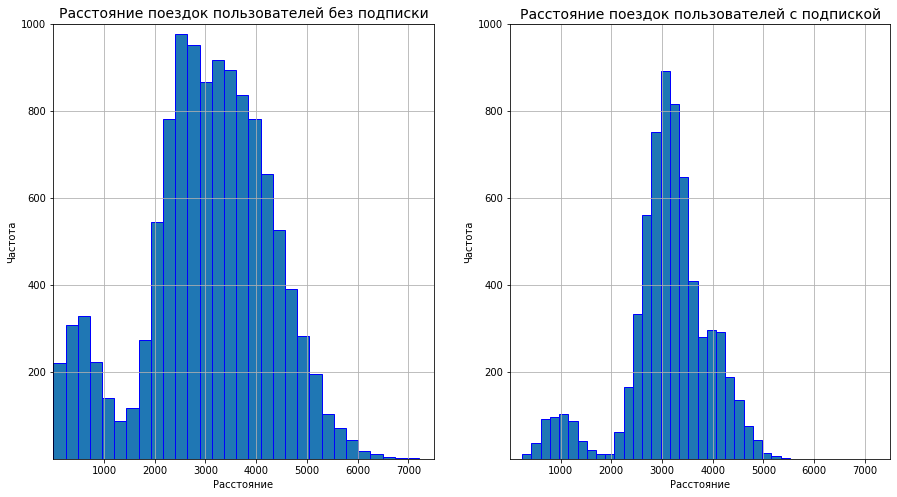

In [35]:
plt.subplot(121)
data_free['distance'].hist(bins=30, figsize=(15, 8), edgecolor='b')
plt.xlim(1, 7500)
plt.ylim(1, 1000)
plt.title('Расстояние поездок пользователей без подписки', fontsize=14)
plt.xlabel('Расстояние')
plt.ylabel('Частота')
plt.subplot(122)
data_ultra['distance'].hist(bins=30, figsize=(15, 8), edgecolor='b')
plt.xlim(1, 7500)
plt.ylim(1, 1000)
plt.title('Расстояние поездок пользователей с подпиской', fontsize=14)
plt.xlabel('Расстояние')
plt.ylabel('Частота')
plt.show()

Совместим гистограммы на одном поле

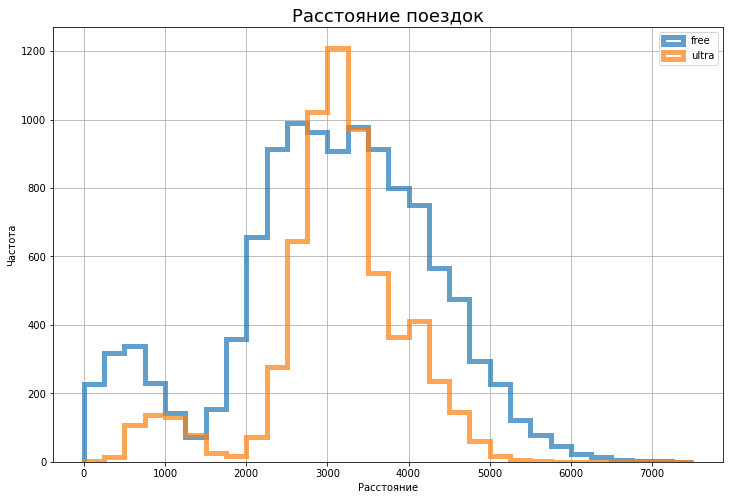

In [36]:
ax = data_free['distance'].plot(
    kind='hist',
    histtype='step',
    range=(0, 7500),
    bins=30,
    figsize=(12, 8),
    linewidth=5,
    alpha=0.7,
    label='free',
    legend=True,
)

data_ultra['distance'].plot(
    kind='hist',
    histtype='step',
    range=(0, 7500),
    bins=30,
    linewidth=5,
    alpha=0.7,
    label='ultra',
    ax=ax,
    grid=True,
    legend=True,
)

plt.title('Расстояние поездок', fontsize=18)
plt.xlabel('Расстояние')
plt.ylabel('Частота')
plt.show()

На совмещённой гистограмме видно, что гистограмма, построенная по данным о расстоянии поездок пользователей с подпиской, более узкая, главный пик у неё более выражен. Это означает, что разброс расстояний поездок клиентов с подпиской меньше, расстояния этих поездок более близки к среднему значению. У пользователей без подписки больше выражен малый пик, то есть, действительно, ошибочных и пробных поездок без подписки заметно больше. Аномальных поездок на расстояния, близкие к нулю, у пользователей с подпиской практически нет.

Построим две гистограммы распределения поездок по времени поездок по данным без подписки и с подпиской

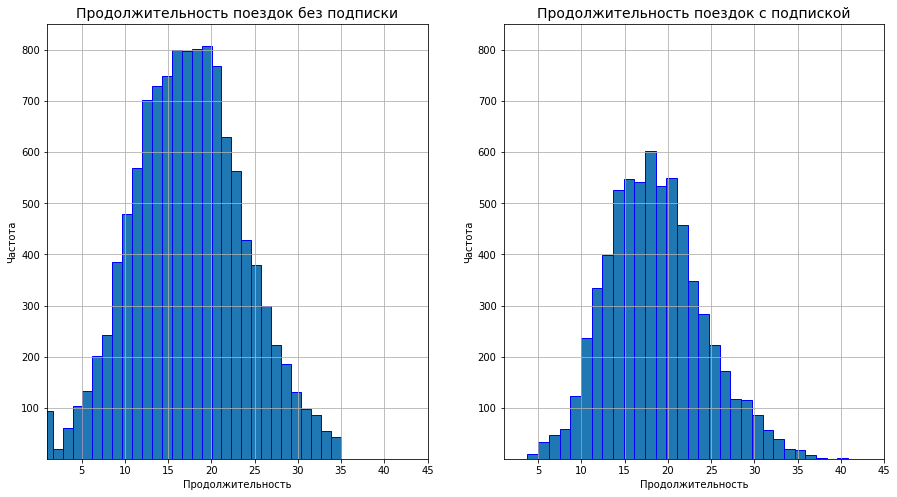

In [37]:
plt.subplot(121)
data_free['duration'].hist(bins=30, figsize=(15, 8), edgecolor='b')
plt.xlim(1, 45)
plt.ylim(1, 850)
plt.title('Продолжительность поездок без подписки', fontsize=14)
plt.xlabel('Продолжительность')
plt.ylabel('Частота')
plt.subplot(122)
data_ultra['duration'].hist(bins=30, figsize=(15, 8), edgecolor='b')
plt.xlim(1, 45)
plt.ylim(1, 850)
plt.title('Продолжительность поездок с подпиской', fontsize=14)
plt.xlabel('Продолжительность')
plt.ylabel('Частота')
plt.show()

Совместим гистограммы на одном поле

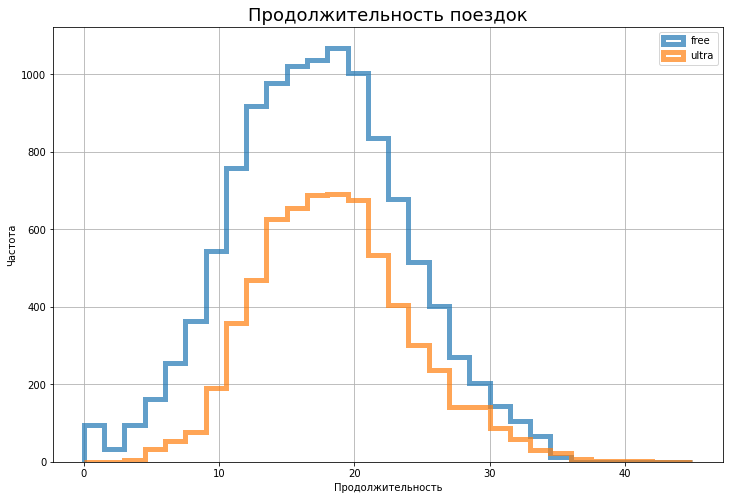

In [38]:
ax = data_free['duration'].plot(
    kind='hist',
    histtype='step',
    range=(0, 45),
    bins=30,
    figsize=(12, 8),
    linewidth=5,
    alpha=0.7,
    label='free',
    legend=True,
)

data_ultra['duration'].plot(
    kind='hist',
    histtype='step',
    range=(0, 45),
    bins=30,
    linewidth=5,
    alpha=0.7,
    label='ultra',
    ax=ax,
    grid=True,
    legend=True,
)

plt.title('Продолжительность поездок', fontsize=18)
plt.xlabel('Продолжительность')
plt.ylabel('Частота')
plt.show()

Совместная гистограмма показывает, что распределение поездок пользователей без подписки и с подпиской очень похоже. Разница состоит в том, что практически отсутствуют аномально короткие по времени поездки. Такие аномалии наблюдаются только у пользователей без подписки. Это указывает на то, что пользователи без подписки бывают неопытными, не всегда знают, как пользоваться приложением или самокатом, пробуют, ошибаются, учатся. А пользователи с подпиской знают что и как, взяли самокат и поехали куда планировали.

Выведем на экран среднее расстояние и время поездок пользователей без подписки и с подпиской

In [39]:
print('Среднее расстояние поездок пользователей без подписки', data_free['distance'].mean().round(2),\
      ', с подпиской', data_ultra['distance'].mean().round(2))
print('Среднее время поездок пользователей без подписки', data_free['duration'].mean().round(2),\
      ', с подпиской', data_ultra['duration'].mean().round(2))

Среднее расстояние поездок пользователей без подписки 3045.5 , с подпиской 3115.45
Среднее время поездок пользователей без подписки 17.39 , с подпиской 18.54


**Сравнение статистик у двух групп пользователей**

Воспользуемся методом `describe()`, чтобы получить числовое описание поездок по двум группам пользователей (без подписки и с подпиской) по столбцу `distance`

In [40]:
display(data_free['distance'].describe().round(2))
display(data_ultra['distance'].describe().round(2))

count    11568.00
mean      3045.50
std       1246.17
min          0.86
25%       2366.56
50%       3114.65
75%       3905.70
max       7211.01
Name: distance, dtype: float64

count    6500.00
mean     3115.45
std       836.90
min       244.21
25%      2785.44
50%      3148.64
75%      3560.57
max      5699.77
Name: distance, dtype: float64

Число поездок пользователей без подписки значительно больше числа поездок пользователей с подпиской, посчитаем соотношение

In [41]:
display(data_free['distance'].count() / data_ultra['distance'].count())

1.7796923076923077

Пользователи без подписки совершили на 78 % поездок больше, чем пользователи с подпиской. Но средняя дистанция поездки у клиентов с подпиской больше. Кроме того, разброс значений у клиентов без подписки значительно больше. Минимальная поездка составляет меньше метра, стандартное отклонение значительно больше, межквартильный размах гораздо шире, чем у клиентов с подпиской. Подтверждаются выводы, сделанные по графическим изображениям.

Методом `describe()`, получим числовое описание поездок по двум группам пользователей (без подписки и с подпиской) по столбцу `duration`

In [42]:
display(data_free['duration'].describe().round(2))
display(data_ultra['duration'].describe().round(2))

count    11568.00
mean        17.39
std          6.33
min          0.50
25%         12.96
50%         17.33
75%         21.59
max         34.95
Name: duration, dtype: float64

count    6500.00
mean       18.54
std         5.57
min         3.76
25%        14.52
50%        18.18
75%        21.88
max        40.82
Name: duration, dtype: float64

По продолжительности поездок разница между группами пользователей не такая ярко выраженная. Средняя продолжительность различается всего на одну минуту, медианная - даже меньше, чем на одну минуту. Остальные показатели тоже различаются ненамного. Но разброс продолжительности поездок у клиентов без подписки, как показывает стандартное отклонение, всё-таки выше. У них минимальная поездка длилась всего полминуты, что указывает также на наличие ошибок при использовании приложения или использовании самокатов.

**Распределение поездок по городам и сезонам**

Напишем функцию для определения сезонов

In [43]:
def seasons(month):
    try:
        if 3 <= month <= 5:
            return 'spring'
        elif 6 <= month <= 8:
            return 'summer'
        elif 9 <= month <= 11:
            return 'autumn'
        elif month < 3 or month == 12:
            return 'winter'        
    except:
        pass

Добавим в объединенный датафрейм `data` столбец `season`

In [44]:
data['season'] = data['month'].apply(seasons)
data.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee,season
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199,winter
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199,winter
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199,spring
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199,summer
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199,summer


Посчитаем число поездок по сезонам

In [45]:
data['season'].value_counts()

spring    4610
summer    4600
winter    4448
autumn    4410
Name: season, dtype: int64

Посчитаем, сколько в процентах составляет разница числа поезок летом и зимой

In [46]:
data.loc[data['season'] == 'summer']['user_id'].count() / data.loc[data['season'] == 'winter']['user_id'].count()

1.0341726618705036

Весной и летом зафиксировано поездок больше, чем осенью и зимой. Однако число поездок летом всего на `3.4` процента больше, чем зимой. Рассмотрим число поездок по сезонам более подробно, по городам.

Построим горизонтальную столбчатую диаграмму, используя сводную таблицу

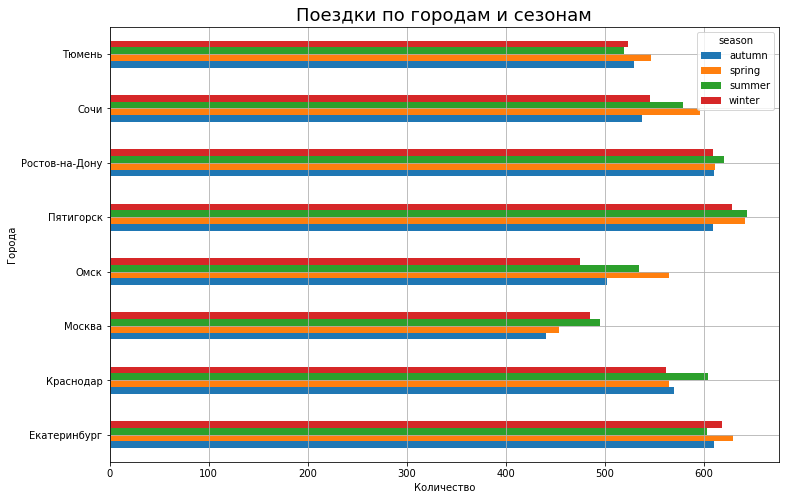

In [47]:
data.pivot_table(index='city', columns='season', values='distance', aggfunc='count')\
.plot(kind='barh', figsize=(12, 8), grid=True)
plt.title('Поездки по городам и сезонам', fontsize=18)
plt.xlabel('Количество')
plt.ylabel('Города')
plt.show()

Вывод по городам и сезонам получился непредсказуемый. Оказывается, в сибирских городах Омске и Тюмени, а также в Москве в зимние месяцы сервис аренды самокатов действует так же активно, как в другие сезоны. Да, в Омске зимой поездок меньше, чем в другие сезоны. Но в Тюмени особой разницы не видно, причем зимой число поездок даже больше, чем летом. И в Москве зимой число поездок сравнимо с летними месяцами. Это странная статистика. Объяснить её нельзя.

**Вывод**. Мною объединены данные из трёх датафреймов в один. А затем был разделен этот датафрейм на два - по группам пользователей. Проверка показала, что после объединения и разделения пропусков не появилось.  
Пользователи без подписки совершили на 78 % поездок больше, чем пользователи с подпиской. Но среднее расстояние поездок у пользователей с подпиской больше. Разброс поездок по времени и расстоянию поездок у пользователей без подписки больше, чем у пользователей с подпиской. Большое влияние на это, скорей всего, оказало наличие среди пользователей без подписки определенного количества неопытных пользователей, которые ошибаются при использовании приложения или при использовании самоката, отчего поездки у них получаются маленькими по расстоянию и по продолжительности.  
Анализ поездок по городам и сезонам дал странные результаты: в сибирских городах зимой самокаты используются так же активно, как и летом, чего быть явно не может.

# Шаг 5. Подсчёт выручки

**Создание таблицы с агрегированными данными**

Для расчета выручки округляем продолжительность каждой поездки в каждой строке датафрейма `data`,так как оплата поездки пользователем выполняется по времени, округлённому в большую сторону до целых минут

In [48]:
data['duration'] = np.ceil(data['duration'])

data.head(20)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee,season
0,1,Кира,22,Тюмень,ultra,4409.919140,26.0,2021-01-01,1,6,0,199,winter
1,1,Кира,22,Тюмень,ultra,2617.592153,16.0,2021-01-18,1,6,0,199,winter
2,1,Кира,22,Тюмень,ultra,754.159807,7.0,2021-04-20,4,6,0,199,spring
3,1,Кира,22,Тюмень,ultra,2694.783254,19.0,2021-08-11,8,6,0,199,summer
4,1,Кира,22,Тюмень,ultra,4028.687306,27.0,2021-08-28,8,6,0,199,summer
5,1,Кира,22,Тюмень,ultra,2770.890808,17.0,2021-10-09,10,6,0,199,autumn
6,1,Кира,22,Тюмень,ultra,3039.020292,15.0,2021-10-19,10,6,0,199,autumn
7,1,Кира,22,Тюмень,ultra,2842.118050,24.0,2021-11-06,11,6,0,199,autumn
8,1,Кира,22,Тюмень,ultra,3412.690668,16.0,2021-11-14,11,6,0,199,autumn
9,1,Кира,22,Тюмень,ultra,748.690645,16.0,2021-11-22,11,6,0,199,autumn


Методом groupby() сгруппируем данные по пользователям и месяцам, применим агрегации к столбцам группировки agg(), чтобы в таблице вывести данные, необходимые для расчета выручки

In [49]:
data_grouped = (
    data.groupby(['user_id', 'month'])
    .agg({'duration':['sum', 'count'], 'minute_price': 'first', 'start_ride_price': 'first', 'subscription_fee': 'first', 'subscription_type': 'first'})
)

data_grouped.head()

duration       minute_price start_ride_price subscription_fee  \
                   sum count        first            first            first   
user_id month                                                                 
1       1         42.0     2            6                0              199   
        4          7.0     1            6                0              199   
        8         46.0     2            6                0              199   
        10        32.0     2            6                0              199   
        11        56.0     3            6                0              199   

              subscription_type  
                          first  
user_id month                    
1       1                 ultra  
        4                 ultra  
        8                 ultra  
        10                ultra  
        11                ultra

Переименуем столбцы

In [50]:
data_grouped.columns = ['total_duration', 'trips_number', 'minute_price', 'start_ride_price', 'subscription_fee', 'subscription_type']

data_grouped.head()

total_duration  trips_number  minute_price  start_ride_price  \
user_id month                                                                 
1       1                42.0             2             6                 0   
        4                 7.0             1             6                 0   
        8                46.0             2             6                 0   
        10               32.0             2             6                 0   
        11               56.0             3             6                 0   

               subscription_fee subscription_type  
user_id month                                      
1       1                   199             ultra  
        4                   199             ultra  
        8                   199             ultra  
        10                  199             ultra  
        11                  199             ultra

Проверим агрегированные данные на пропуски

In [51]:
data_grouped.isna().sum()

total_duration       0
trips_number         0
minute_price         0
start_ride_price     0
subscription_fee     0
subscription_type    0
dtype: int64

Пропусков в датафрейме `data_grouped` нет.

**Расчет помесячной выручки**

Для расчета помесячной выручки напишем собственную функцию

In [52]:
def revenue(row):
    start_sum = row['start_ride_price'] * row['trips_number']
    trip_sum = row['minute_price'] * row['total_duration']
    subscription_fee = row['subscription_fee']
    result = start_sum + trip_sum + subscription_fee
    return result

Проверим корректность работы функции

In [53]:
row_values = [42, 2, 6, 0, 199]
row_columns = ['total_duration', 'trips_number', 'minute_price', 'start_ride_price', 'subscription_fee']
row = pd.Series(data=row_values, index=row_columns) 
revenue(row)

451

Создадим в таблице `data_grouped` новый столбец `revenue`, для расчета значений в нём воспользуемся написанной нами функцией и методом `apply`
<br>
Выведем на экран 20 первых и 20 последних строк датафрейма `data_grouped` с новым столбцом `revenue`

In [54]:
data_grouped['revenue'] = data_grouped.apply(revenue, axis=1)

data_grouped.head(20)

total_duration  trips_number  minute_price  start_ride_price  \
user_id month                                                                 
1       1                42.0             2             6                 0   
        4                 7.0             1             6                 0   
        8                46.0             2             6                 0   
        10               32.0             2             6                 0   
        11               56.0             3             6                 0   
        12               28.0             2             6                 0   
2       3                63.0             3             6                 0   
        4                40.0             2             6                 0   
        6                14.0             1             6                 0   
        7                48.0             2             6                 0   
        8                 7.0             1             6                 0   
        10               19.0             1             6                 0   
        12               12.0             1             6                 0   
3       1                13.0             1             6                 0   
        2                39.0             2             6                 0   
        4                21.0             1             6                 0   
        5                63.0             3             6                 0   
        7                67.0             3             6                 0   
        9                23.0             1             6                 0   
        12               13.0             1             6                 0   

               subscription_fee subscription_type  revenue  
user_id month                                               
1       1                   199             ultra    451.0  
        4                   199             ultra    241.0  
        8                   199             ultra    475.0  
        10                  199             ultra    391.0  
        11                  199             ultra    535.0  
        12                  199             ultra    367.0  
2       3                   199             ultra    577.0  
        4                   199             ultra    439.0  
        6                   199             ultra    283.0  
        7                   199             ultra    487.0  
        8                   199             ultra    241.0  
        10                  199             ultra    313.0  
        12                  199             ultra    271.0  
3       1                   199             ultra    277.0  
        2                   199             ultra    433.0  
        4                   199             ultra    325.0  
        5                   199             ultra    577.0  
        7                   199             ultra    601.0  
        9                   199             ultra    337.0  
        12                  199             ultra    277.0

In [55]:
data_grouped.tail(20)

total_duration  trips_number  minute_price  start_ride_price  \
user_id month                                                                 
1532    8                47.0             2             8                50   
        10               21.0             1             8                50   
        11               60.0             4             8                50   
        12               42.0             2             8                50   
1533    1                21.0             1             8                50   
        2                11.0             1             8                50   
        3                93.0             4             8                50   
        4                18.0             1             8                50   
        6                 7.0             1             8                50   
        7                48.0             3             8                50   
        8                22.0             1             8                50   
        11               26.0             1             8                50   
1534    1                16.0             1             8                50   
        2                14.0             1             8                50   
        4                15.0             1             8                50   
        6                26.0             2             8                50   
        8                48.0             2             8                50   
        9                23.0             1             8                50   
        11               78.0             4             8                50   
        12               16.0             1             8                50   

               subscription_fee subscription_type  revenue  
user_id month                                               
1532    8                     0              free    476.0  
        10                    0              free    218.0  
        11                    0              free    680.0  
        12                    0              free    436.0  
1533    1                     0              free    218.0  
        2                     0              free    138.0  
        3                     0              free    944.0  
        4                     0              free    194.0  
        6                     0              free    106.0  
        7                     0              free    534.0  
        8                     0              free    226.0  
        11                    0              free    258.0  
1534    1                     0              free    178.0  
        2                     0              free    162.0  
        4                     0              free    170.0  
        6                     0              free    308.0  
        8                     0              free    484.0  
        9                     0              free    234.0  
        11                    0              free    824.0  
        12                    0              free    178.0

**Расчет годовой выручки**

Рассчитаем общую годовую выручку

In [56]:
total_revenue = data_grouped.revenue.sum()
total_revenue

3878641.0

Рассчитаем показатели суммарной годовой выручки для пользователей с подпиской и без подписки. Методом `query()` выполним срезы данных, зная, что у пользователей с подпиской в столбце `subscription_fee` стоит значение 199, а у пользователей без подписки значение 0

In [57]:
total_revenue_free = data_grouped.query('subscription_fee == 0').revenue.sum()
total_revenue_ultra = data_grouped.query('subscription_fee == 199').revenue.sum()
print('Годовая выручка от пользователей без подписки', total_revenue_free)
print('Годовая выручка от пользователей с подпиской', total_revenue_ultra)

total_revenue_free + total_revenue_ultra == total_revenue

Годовая выручка от пользователей без подписки 2234104.0
Годовая выручка от пользователей с подпиской 1644537.0


True

**Расчет среднемесячной выручки среднего пользователя для каждого тарифа**

In [58]:
month_revenue = data_grouped['revenue'].sum() / len(data_grouped)
month_revenue.round(2)

342.3

In [59]:
month_revenue_free = data_grouped.query('subscription_fee == 0').revenue.sum() / len(data_grouped.query('subscription_fee == 0'))
month_revenue_free.round(2)

328.64

In [60]:
month_revenue_ultra = data_grouped.query('subscription_fee == 199').revenue.sum() / len(data_grouped.query('subscription_fee == 199'))
month_revenue_ultra.round(2)

362.79

**Вывод.** Мною сгруппированы данные по пользователям и месяцам и рассчитана помесячная выручка по каждому пользователю. Общая выручка составила `3878641.0` рублей. Годовая выручка от клиентов без подписки выше, чем от клиентов с подпиской (`2234104` и `1644537` руб. соответственно).  
Среднемесячная выручка среднего пользователя составила `342.30` руб. Среднемесячная выручка пользователя без подписки составила `328.64` руб., с подпиской - `362.79` руб.

# Шаг 6. Проверка гипотез

Продакт-менеджеры сервиса хотят увеличить количество пользователей с подпиской. Для этого они будут проводить различные акции. Но сначала нужно выяснить несколько важных моментов.

**Время, затрачиваемое на поездки**

Важно понять, тратят ли пользователи с подпиской больше времени на поездки. Если да, то пользователи с подпиской могут быть "выгоднее" для компании.

Сформулируем нулевую гипотезу: Н<sub>0</sub>: средняя продолжительность одной сессии для пользователей с подпиской равна средней продолжительности сессии пользователей без подписки. Альтернативная гипотеза Н<sub>1</sub>: средняя продолжительность сессии пользователей с подпиской больше средней продолжительности сессии пользователей без подписки.

Для анализа используем данные столбца `duration` из датафреймов `data_ultra` и `data_free`.

Имеются две выборки, взятые независимо друг от друга из двух генеральных совокупностей

In [61]:
duration_ultra = data_ultra['duration']
duration_free = data_free['duration']

Найдём выборочные средние

In [62]:
print(f'Среднее для пользователей с подпиской: {np.mean(duration_ultra)}')
print(f'Среднее для пользователей без подписки: {np.mean(duration_free)}')

Среднее для пользователей с подпиской: 18.54198516280583
Среднее для пользователей без подписки: 17.39090929866399


Для проверки гипотезы о равенстве средних двух генеральных совокупностей применяем метод `scipy.stats.ttest_ind`. Аргументами метода являются две выборки `duration_ultra` и `duration_free`. Полагаем, что дисперсии генеральных совокупностей равны, поэтому агрумент `equal_var` не указываем.Так как альтернативная гипотеза правосторонняя, указываем аргумент `alternative='greater'`

In [63]:
alpha = 0.05
results = st.ttest_ind(
    duration_ultra,
    duration_free,
    alternative='greater'
)

Выведем полученное p-value и сделаем вывод об отвержении или неотвержении нулевой гипотезы

In [64]:
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 1.2804098316645618e-34
Отвергаем нулевую гипотезу


Полученное значение p_value очень мало, близко к нулю. Такое значение говорит о том, что хоть различие средней продолжительности сессии для пользователей с подпиской и без подписки небольшое, вероятность получить такое различие случайно практически нулевая, то есть имеет место значимое различие между средними сессиями. Есть основания отвергнуть нулевую гипотезу о равенстве средних сессий.
Таким образом, нулевая гипотеза о равенстве времени, затрачиваемого на поездки пользователями с подпиской и без подписки, отвергнута при уровне статистической значимости, равном 5 %. Она была бы отвергнута и при уровне статистической значимости 1 %. Можно сделать вывод, что среднее время, затрачиваемое на поездки пользователями с подпиской, в генеральной совокупности больше, чем среднее время, затрачиваемое на поездки пользователями без подписки.

**Вывод**: Судя по продолжительности поездок, пользователи с подпиской "выгоднее" для компании, чем пользователи без подписки.

**Расстояние одной поездки**

Расстояние одной поездки в 3130 метров - оптимальное с точки зрения износа самоката. Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?

Сформулируем нулевую гипотезу Н<sub>0</sub>: расстояние, которое проезжают пользователи с подпиской за одну поездку, равно 3130 метров. Альтернативная гипотеза Н<sub>1</sub>: расстояние, которое проезжают пользователи с подпиской за одну поездку, больше 3130 метров.

Для анализа используем данные столбца `distance` из датафрейма `data_ultra`.

In [65]:
distance = data_ultra['distance']

print('Среднее расстояние одной поездки:', distance.mean())

Среднее расстояние одной поездки: 3115.4453880370247


Предположенное в нулевой гипотезе число. С  помощью теста проверяется гипотеза о том, что этому числу равно истинное среднее генеральной совокупности, из которой взята выборка (расстояние одной поездки пользователей с подпиской)
<br>
Для проверки гипотезы о равенстве среднего значения генеральной совокупности заданному значению применяем метод `scipy.stats.ttest_1samp`. Аргументами метода являются выборка `distance` и предполагаемое среднее 3130.Так как альтернативная гипотеза правосторонняя, указываем аргумент `alternative='greater'`

In [66]:
value = 3130
alpha = 0.05

results = st.ttest_1samp(
    distance, 3130,
    alternative='greater'
)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-значение: 0.9195368847849785
Не отвергаем нулевую гипотезу


Выборочное среднее равно 3115.4453880370247, это меньше заданного значения 3130. Кроме того, `p-value` больше выбранного уровня статистической значимости. Поэтому нет оснований отвергуть нулевую гипотезу. Можно сделать вывод, что истинное среднее генеральной совокупности, из которой выборка взята, не превышает значение 3130. Таким образом, расстояние, которое проезжают пользователи с подпиской за одну поездку, в среднем не превышают оптимальное с точки зрения износа самоката расстояние в 3130 метров.

**Вывод**: Судя по расстоянию одной поездки, пользователи с подпиской не увеличивают износ самоката, так как расстояние одной поездки не превышает оптимальное с точки зрения износа самоката расстояние.

**Помесячная выручка**

Проверим гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

Сформулируем нулевую гипотезу Н<sub>0</sub>: средняя выручка за месяц от пользователей с подпиской равна средней выручке за месяц от пользователей без подписки. Альтернативная гипотеза Н<sub>1</sub>: средняя выручка за месяц от пользователей с подпиской выше, чем средняя выручка за месяц от пользователей без подписки.

Для анализа используем данные столбца `revenue` датафрейма `data_grouped`. Для формирования выборок необходимо сделать срезы по пользователям с подпиской и без подписки.

Для проверки гипотезы о равенстве средних двух генеральных совокупностей применяем метод `scipy.stats.ttest_ind`.Аргументами метода являются две выборки `revenue_ultra` и `revenue_free`.Полагаем, что дисперсии генеральных совокупностей равны, поэтому агрумент `equal_var` не указываем.Так как альтернативная гипотеза правосторонняя, указываем аргумент `alternative='greater`. Затем выведем полученное p-value и сделаем ывод об отвержении или неотвержении нулевой гипотезы

In [67]:
revenue_ultra = data_grouped.query('user_id in@data_ultra.user_id')['revenue']
revenue_free = data_grouped.query('user_id in@data_free.user_id')['revenue']

print(f'Среднее для пользователей с подпиской: {np.mean(revenue_ultra).round(2)}')
print(f'Среднее для пользователей без подписки: {np.mean(revenue_free).round(2)}')

alpha = 0.05

results = st.ttest_ind(
    revenue_ultra,
    revenue_free,
    alternative='greater'
)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Среднее для пользователей с подпиской: 362.79
Среднее для пользователей без подписки: 328.64
p-значение: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


Нулевая гипотеза о равенстве помесячной выручки от пользователей с подпиской и без подписки, отвергнута при уровне статистической значимости, равном 5 %. Она была бы отвергнута и при уровне статистической значимости 1 %. Можно сделать вывод, что средняя выручка за месяц от пользователей с подпиской, в генеральной совокупности выше, чем средняя выручка за месяц от пользователей без подписки.

**Вывод**: Судя по выручке за месяц, пользователи с подпиской "выгоднее" для компании, так как помесячная выручка от них в среднем выше, чем от пользователей без подписки.

**Обновление серверов**

Представим такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

В данном случае имеются две зависимые (парные) выборки. Проверяется гипотеза о равенстве среднего значения генеральной совокупности до и после изменения. Для проверки гипотезы нужно использовать метод `scipy.stats.ttest_rel`. Аргументы этого метода - парные выборки до и после изменения.  

В качестве нулевой гипотезы указываем: среднее значение до и после изменения равны. В качестве альтернативной гипотезы берём: среднее значение до изменения больше, чем после изменения. То есть проверяем одностороннюю гипотезу, в данном случае правостороннюю.

# Шаг 7. Распределения

**Акция с раздачей промокодов**

Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж.

Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Необходимо выяснить, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Необходимо подобрать параметры распределения, описывающего эту ситуацию, построить график распределения и сформулировать ответ на вопрос о количестве промокодов.

Разберёмся.  

Случайная величина - количество продлений подписки после пробного периода - распределена биномиально, так как:
- проводится фиксированное число попыток `n`;
- каждая попытка - простой эксперимент Бернулли ровно с двумя исходами (продление или непродление подписки);
- вероятность успеха `p = 0.1` одинакова для всех `n` попыток;
- попытки независимы между собой.

Чтобы определить биномиальное распределение, нужны два параметра: количество попыток `n` и вероятность успеха `p`. Количество попыток нам неизвестно. Математическое ожидание рассчитывается как `n * p`, а дисперсия `n * p * (1-p)`.

Если должны продлить подписку 100 существующих клиентов (математическое ожидание), а вероятность продления 0.1, то параметр `n` можно найти как `100 / 0.1 = 1000`. Построим распределение вероятностей и гистограмму для случайной величины `количество продлений` , если раздали 1000 промокодов.

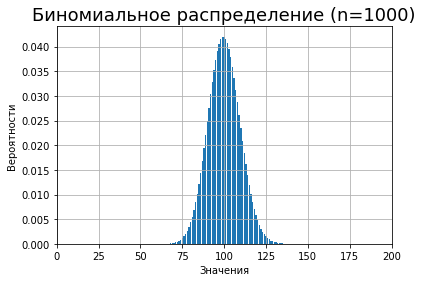

In [68]:
p = 0.1
n = 1000

distr = []

for k in range(0, n + 1):
    choose = factorial(n) / (factorial(k) * factorial(n - k))
    prob = choose * p**k * (1 - p)**(n - k) 
    distr.append(prob)

plt.figure(figsize=(6, 4))
plt.bar(range(0, n+1), distr)
plt.xlim(0, 200)
plt.title('Биномиальное распределение (n=1000)', fontsize=18)
plt.xlabel('Значения')
plt.ylabel('Вероятности')
plt.grid(True)
plt.show()

Действительно, 100 - самое вероятное значение. Однако на гистограмме видно, что примерно половина всего распределения находится в диапазоне меньше 100.  

100 существующих клиентов должны продлить подписку. Т.е. мы ищем `X` - количество промокодов, которые мы раздадим, чтобы сохранить 100 клиентов.  

Вероятность не выполнить план должна быть примерно 5 %. То есть вероятность успеха нашей акции должна быть `1 - 0.05 = 0.95`, т.е. 95 %. 

Наш план будет иметь свою вероятность успеха при разном количестве `X`, чем больше `X`, тем больше вероятность. Но, увеличивая количество промокодов, мы увеличиваем трудозатраты, финансовые затраты и т.д. Поэтому нас устроит вероятность успеха 95 %, для которой и предстоит рассчитать количество промокодов `X`.  

Задача делится на две части:  
1) число положительных исходов должно быть равно 100,
2) вероятность такого события должна быть равна 95 %.

У нас требуемое значение 100 или больше. Кумулятивная функция распределения - это функция, которая показывает вероятность того, что случайная величина будет меньше или равна некоторому значению. За это значение принимаем 99. Тогда мы из `1` вычитаем вероятность получить значение меньше или равно 99, это и будет вероятность получить значение 100 или больше.

Посмотрим, каковы вероятности, что продлят подписку 100 или больше пользователей при разных количествах розданных промокодов.

In [69]:
for i in range (1, 15):
    # число розданных промокодов
    trials = 100 * i
    print(f"i: {i, trials}\tprobability: {(1 - st.binom.cdf(99, trials, 0.1)).round(3)}")

i: (1, 100)	probability: 0.0
i: (2, 200)	probability: 0.0
i: (3, 300)	probability: 0.0
i: (4, 400)	probability: 0.0
i: (5, 500)	probability: 0.0
i: (6, 600)	probability: 0.0
i: (7, 700)	probability: 0.0
i: (8, 800)	probability: 0.013
i: (9, 900)	probability: 0.146
i: (10, 1000)	probability: 0.515
i: (11, 1100)	probability: 0.855
i: (12, 1200)	probability: 0.978
i: (13, 1300)	probability: 0.998
i: (14, 1400)	probability: 1.0


Искомое количество промокодов находится где-то в промежутке между 1100 и 1200.  
Опять используем метод `binom.cdf()` в цикле.

In [70]:
for n in range(1100, 1200):
    if (1 - st.binom.cdf(99, n, 0.1)) > 0.95:
        break
    
print(n)  

1161


/opt/conda/lib/python3.9/site-packages/scipy/stats/_discrete_distns.py:78: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


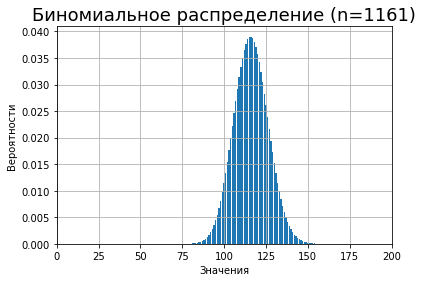

In [71]:
#Задаем параметры
n = 1161
p = 0.1

distr = []

for k in range(0, n + 1):
    try:
        current_value = binom.pmf(k, n, p)
        distr.append(current_value)
    except:
        pass

plt.figure(figsize=(6, 4))
plt.bar(range(0, n+1), distr)
plt.xlim(0, 200)
plt.title('Биномиальное распределение (n=1161)', fontsize=18)
plt.xlabel('Значения')
plt.ylabel('Вероятности')
plt.grid(True)
plt.show()

Действительно, на графике видно, что меньше значения 100 примерно 5 % площади, занимаемой столбцами диаграммы.

**Вывод.** Чтобы с вероятностью примерно 5 % как минимум 100 существующих клиентов продлили подписку после месяца использования промокода, нужно в рамках акции раздать более 1161 промокодов.

**Рассылка push-уведомлений**

Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн. уведомлений. С помощью аппроксимации построим примерный график распределения и оценим вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

Случайная величина - количество открытий push-сообщений - распределена биномиально, так как:

- проводится фиксированное число попыток n;
- каждая попытка - простой эксперимент Бернулли ровно с двумя исходами (открытие или неоткрытие сообщения);
- вероятность успеха p = 0.4 одинакова для всех n попыток;
- попытки независимы между собой.

Ситуация описывается биномиальным распределением. Но считать каждое отдельное значение достаточно долго. Можно воспользоваться нормальной аппроксимацией биномиального распределения и cdf() для быстрой оценки.

Значение n = 1000000 велико, а p = 0.4 близко к 0.5, поэтому форма графика биномиального распределения предполагается симметричной и близкой к графику нормального распределение. Поэтому аппроксимация биномиального распределения нормальным получится хорошей.

Проверим это расчетом. Нужно найти промежуток, в котором лежат практически все отличные от нуля вероятности биномиального распределения: математическое ожидание плюс-минус три стандартных отклонения.

Математическое ожидание биномиального распределения n * p, дисперсия n * p * (1 - p).

In [72]:
n = 1000000
p = 0.4
left = int(n * p - 3 * sqrt(n * p * (1 - p)))
right = int(n * p + 3 * sqrt(n * p * (1 - p)))
print(left, right)

398530 401469


Промежуток, в котором лежат практически все отличные от нуля вероятности биномиального распределения, лежит внутри промежутка значений, на которых определено биномиальное распределение (от нуля до n).  Биномиальное распределение достаточно симметрично, чтобы аппроксимировать его нормальным.

Зададим функцию, которая выдаёт `num` чисел,равномерно распределённых от `start` до `stop` (понадобится для визуализации нормального распределения)
<br>
Зададим мат.ожидание и ст.отклонение нормального распределения равными мат.ожиданию и ст.отклонению биномиального распределения

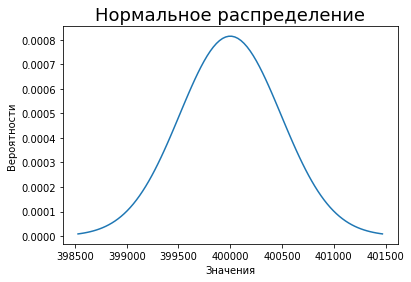

In [73]:
def linspace(start, stop, num):
    step = (stop - start) / (num - 1)
    result = []
    for i in range(num):
        result.append(start + step * i)
    return result
 
mu = n * p
sigma = sqrt(n * p * (1 - p))
 
x = linspace(left, right, 100)

plt.plot(x, norm.pdf(x, mu, sigma))
plt.title('Нормальное распределение', fontsize=18)
plt.xlabel('Значения')
plt.ylabel('Вероятности')
plt.show()

Зададим мат.ожидание и ст.отклонение нормального распределения равными мат.ожиданию и ст.отклонению биномиального распределения. Задаём нормальное распределение и считаем вероятность хвоста слева от 399,5 тысяч

In [74]:
mu = n * p
sigma = sqrt(n * p * (1 - p))

distr = st.norm(mu, sigma) 

result = distr.cdf(399500)
print(result.round(4))

0.1537


**Вывод.** Вероятность того, что уведомление откроют не более 399,5 тысяч пользователей, 15,37 %.

# Общий вывод

Датафрейм users содержит информацию о пользователях, датафрейм rides - информацию о поездках, датафрейм subscriptions - о подписках.

Для дальнейшей работы с данными мною была выполнена их предобработка: тип данных в столбце date датафрейма rides приведён к типу даты pandas, в отдельный столбец month вынесены данные о месяце, убедился в отсутствии пропущенных значений в данных, избавился от явных дубликатов и убедился в отсутствии неявных дубликатов.

Наибольшее число поездок по имеющимся данным совершили пользователи в Пятигорске, Екатеринбурге, Ростове-на-Дону, а также в Краснодаре и Сочи. В Омске, Тюмени и Москве поездок меньше. Совершенно непонятно, почему столь разные города имеют разницу в числе поездок не в пользу Москвы. Однако разница такова, что не играет существенной роли для нашего исследования.

Сервис используют с подпиской или без подписки. Пользователей без подписки примерно на 20 процентов больше, чем с подпиской. Самые активные пользователи сервиса - люди от 22 до 28 лет. За одну сессию чаще всего пользователи проезжают от 2,5 до 3,8 километров. Чаще всего поездка длится от 13 до 22 минут.

Я объединил данные о пользователях, поездках и подписках в один датафрейм, а затем создал два датафрейма отдельно по пользователям без подписки и с подпиской. Проверка показала, что пропусков данных после объединения и разделения не появилось.

Расчет средних значений показал, что пользователи с подпиской проезжают расстояния и проводят в поездках времени в среднем больше, чем пользователи без подписки. Кроме того, разброс значений по длине и времени поездок у пользователей без подписки больше, а совокупность пользователей с подпиской более однородна по этим показателям. Это указывает на то, что пользователи без подписки бывают неопытными, не всегда знают, как пользоваться приложением или самокатом, пробуют, ошибаются, учатся. Время и расстояние их поездок бывает аномально короткими, бывают чересчур длинными. А пользователи с подпиской знают что и как, взяли самокат и поехали куда планировали.

Анализ данных по городам и сезонам дал странные результаты: количество поездок зимой в сибирских городах такое же, как летом. Этого быть не может. Поэтому есть повод передать эти результаты коллегам для перепроверки исходных данных.

Мною сгруппированы данные по пользователям и месяцам, после группировки данные проверены на пропуски, их не обнаружено.

Далее была рассчитана помесячная выручка по каждому пользователю, сведена в таблицу. Это дало возможность сделать окончательные расчёты по выручке. Общая выручка составила `3878641.0` рублей. Годовая выручка от клиентов без подписки выше, чем от клиентов с подпиской (`2234104` и `1644537` рублей соответственно. Среднемесячная выручка среднего пользователя составила 342.30 руб. Среднемесячная выручка пользователя без подписки составила 328.64 руб., с подпиской - 362.79 руб. Получается, что выручка от одного пользователя с подпиской больше, чем от пользователя без подписки. А общая выручка от пользователей с подпиской за год получилась меньше из-за того, что число пользователей с подпиской меньше, чем без подписки.

Мною были сформулированы и проверены некоторые гипотезы. Среднее время, затрачиваемое на поездки пользователями с подпиской, в генеральной совокупности больше, чем среднее время, затрачиваемое на поездки пользователями без подписки. Судя по расстоянию одной поездки, пользователи с подпиской не увеличивают износ самоката, так как расстояние одной поездки не превышает оптимальное с точки зрения износа самоката расстояние. Выручка за месяц от пользователей с подпиской в среднем выше, чем от пользователей без подписки.

Всё это позволило сделать вывод, что пользователи с подпиской "выгоднее" для компании, чем пользователи без подписки. Поэтому рекомендуется увеличивать число пользователей с подпиской.

Если провести акцию с раздачей промокодов на один бесплатный месяц подписки, то чтобы с вероятностью примерно 5 % как минимум 100 существующих клиентов продлили подписку после месяца использования промокода, нужно в рамках акции раздать более 1161 промокодов.

Если рассылать push-уведомления в количестве 1 миллиона, то вероятность того, что уведомление откроют не более 399,5 тысяч пользователей, составит 15,37 %.